# NLP 2020 - HW1

## Q1. Word Classification

### Q1.1. Implement the Evaluation Metrics

Precision attempts to answer the following question:

What proportion of positive identifications was actually correct?

Therefore we will calculate the percentage of true positive out of all the positive identifications.

Recall attempts to answer-
What proportion of actual positives was identified correctly? 

So we would like to look at the percentage of true positive out of all the actual positives.

f-score combine the two using the formula: 2PR/(P + R)

In [1]:
## Calculates the precision of the predicted labels
def get_precision(y_pred, y_true):
    tp = 0
    fp = 0
    for i in range(len(y_pred)):
        p_val = y_pred[i]
        t_val = y_true[i]
        if p_val and t_val:
            tp += 1
        elif p_val and not t_val:
            fp += 1
    precision = tp / (tp + fp)
    return precision
    
## Calculates the recall of the predicted labels
def get_recall(y_pred, y_true):
    tp = 0
    fn = 0
    for i in range(len(y_pred)):
        p_val = y_pred[i]
        t_val = y_true[i]
        if p_val and t_val:
            tp += 1
        elif not p_val and t_val:
            fn += 1

    recall = tp / (tp + fn)
    return recall

## Calculates the f-score of the predicted labels
def get_fscore(y_pred, y_true):
    P = get_precision(y_pred,y_true)
    R = get_recall(y_pred, y_true)
    fscore = 2*P*R / (P + R)
    return fscore

def test_predictions(y_pred, y_true):
    print("Precision:")
    print(get_precision(y_pred, y_true))
    print("Recall:")
    print(get_recall(y_pred, y_true))
    print("fscore:")
    print(get_fscore(y_pred, y_true))
    print("\n")

### Q1.2. Baselines

### 1.2.1 Majority Class Baseline

all_complex is a simple baseline that labels all the word as as complex:

In [2]:
def all_complex(data_file):
    y_true = data_file[1]
    y_pred = []
    for i in range(len(y_true)):
        y_pred.append(1)

    precision = get_precision(y_pred,y_true)
    recall = get_recall(y_pred,y_true)
    fscore = get_fscore(y_pred,y_true)
    performance = [precision, recall, fscore]
    return performance

we'll compute the precision, recall, and f-score for the training data:

In [3]:
## Loads in the words and labels of one of the datasets
def load_file(data_file):
    words = []
    labels = []   
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

if __name__ == "__main__":
    training_file = "../data/complex_words_training.txt"
    development_file = "../data/complex_words_development.txt"
    test_file = "../data/complex_words_test_unlabeled.txt"
    
    train_data = load_file(training_file)
    print(all_complex(train_data))

    dev_data = load_file(development_file)
    print(all_complex(dev_data))

[0.43275, 1.0, 0.604083057058105]
[0.418, 1.0, 0.5895627644569816]


We can see that in both data files recall is always a perfect 1.0.
The reason for it is that if you always label all the words as complex you will never label a complex word wrongly and you will never create a false negative.

Precision is low because there are a lot of words that aren't complex that were labeled as such.


### 1.2.2 Word Length Baseline

we'll try to find the best  threshold by maximizing f-score:

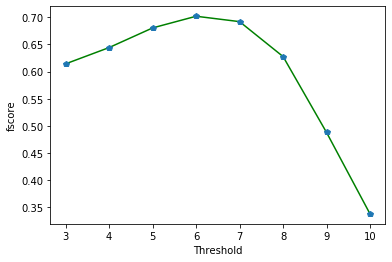

In [4]:
import matplotlib.pyplot as plt

train_data = load_file(training_file)
train_words = train_data[0]
ty_true = train_data[1]

x = []
f = []
for i in range(3,11):
    ty_pred = [1 if len(word) > i else 0 for word in train_words]
    x.append(i)
    f.append(get_fscore(ty_pred,ty_true))

    
plt.xlabel('Threshold')
plt.ylabel('fscore')
plt.plot(x, f, 'g')
plt.plot(x, f, 'p')
plt.show()

The best threshold is 6 (f-score at its max value).

Let's plot the Precision (on the y-axis) and Recall (on the X-axis) for different values of word-length threshold: 

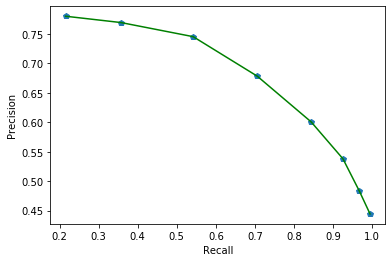

In [5]:
p = []
r = []
for i in range(3,11):
    ty_pred = [1 if len(word) > i else 0 for word in train_words]
    p.append(get_precision(ty_pred,ty_true))
    r.append(get_recall(ty_pred, ty_true))
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(r, p, 'p')
plt.plot(r, p, 'g')
plt.show()

we can see how Precision and Recall are inversely related. 

now we can campute the precision, recall, and f-score for the training and development data:

In [6]:
def word_length_threshold(training_file, development_file):
    train_data = load_file(training_file)
    train_words = train_data[0]
    ty_true = train_data[1]

    dev_data = load_file(development_file)
    dev_words = dev_data[0]
    dy_true = dev_data[1]

    # we found that 6 is the best threshold
    threshold = 6
    print("The performance for training data: ")
    ty_pred = [1 if len(word) > threshold else 0 for word in train_words]
    test_predictions(ty_pred,ty_true)


    print("\nThe performance for development data: ")
    dy_pred = [1 if len(word) > threshold else 0 for word in dev_words]
    test_predictions(dy_pred,dy_true)
    
dev_data = load_file(development_file)
word_length_threshold(training_file, development_file)


The performance for training data: 
Precision:
0.6007401315789473
Recall:
0.8440207972270364
fscore:
0.7018976699495555



The performance for development data: 
Precision:
0.6053511705685619
Recall:
0.8660287081339713
fscore:
0.7125984251968505




### 1.2.3 Word Frequency Baseline

In [7]:
from collections import defaultdict
import gzip
import matplotlib.pyplot as plt

## Loads Google NGram counts
def load_ngram_counts(ngram_counts_file):
    
    counts = defaultdict(int) 
    with gzip.open(ngram_counts_file, 'rt', errors='ignore') as f: 
        for line in f:
            token, count = line.strip().split('\t') 
            if token[0].islower(): 
                counts[token] = int(count) 
    return counts

First, we'll define find_opt_threshold that finds the best threshold by maximizing f-score. 

we'll try different frequencies between 1000 and 50000000.

find_opt_threshold also plot the Precision-Recall curve for the range of thresholds.

In [8]:
def find_opt_threshold(y_true, word_lst, counts):
    max_fscore = 0

    x = []
    f = []
    p = []
    r = []
    for i in range(1000, 50000000, 10000):
        ty_pred = [1 if counts[word] < i else 0 for word in word_lst]
        curr_fscore = get_fscore(ty_pred, y_true)

        if curr_fscore > max_fscore:
            max_fscore = curr_fscore
            opt_threshold = i
        x.append(i)
        f.append(curr_fscore)

        p.append(get_precision(ty_pred, y_true))
        r.append(get_recall(ty_pred, y_true))

    print("The best fscore is: ", max_fscore, "by using the threshold: ", opt_threshold)

    plt.xlabel('Threshold')
    plt.ylabel('fscore')
    plt.plot(x, f, 'b')
    plt.show()

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot(r, p, 'g')
    plt.show()

    return opt_threshold


Now we can find the best thershold using the function and report the precision, recall, and f-score on the training and development data.


The best fscore is:  0.6680861130825645 by using the threshold:  19841000


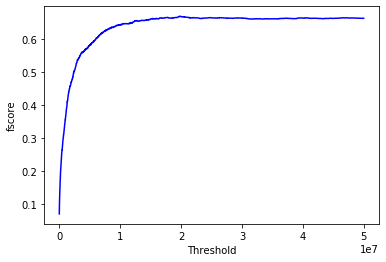

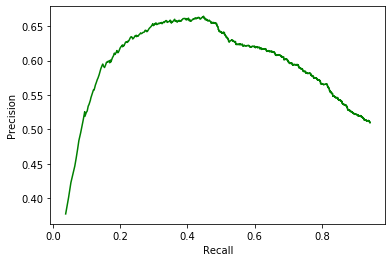

The performance for training data:
Precision:
0.5657051282051282
Recall:
0.8157134604274986
fscore:
0.6680861130825645


The performance for development data: 
Precision:
0.556782334384858
Recall:
0.8444976076555024
fscore:
0.6711026615969581




In [9]:
# Finds the best frequency threshold by f-score, and uses this threshold to
## classify the training and development set
def word_frequency_threshold(training_file, development_file, counts):
    train_data = load_file(training_file)
    train_words = train_data[0]
    ty_true = train_data[1]

    dev_data = load_file(development_file)
    dev_words = dev_data[0]
    dy_true = dev_data[1]

    # finding the best threshold
    opt_thershold = find_opt_threshold(ty_true, train_words, counts)
    
    #using the best threshold:  
    print("The performance for training data:")
    ty_pred = [1 if counts[word] < opt_thershold else 0 for word in train_words]
    test_predictions(ty_pred,ty_true)


    print("The performance for development data: ")
    dy_pred = [1 if counts[word] < opt_thershold else 0 for word in dev_words]
    test_predictions(dy_pred,dy_true)
    

counts = load_ngram_counts("ngram_counts.txt.gz")
word_frequency_threshold(training_file, development_file, counts)

### Q1.3. Classifiers

### 1.3.1 Naive Bayes classification

First, we'll add some functions that will help us normalize the features. get_mean and get_SD returns arrays with the mean and the standard deviation for every feature.

In [10]:
import statistics

def get_mean(words, counts):
    lens = [len(word) for word in words]
    freq = [counts[word] for word in words]
    return [statistics.mean(lens), statistics.mean(freq)]

def get_SD(words, counts):
    lens = [len(word) for word in words]
    freq = [counts[word] for word in words]
    return [statistics.stdev(lens),statistics.stdev(freq)]

normalize_features computes: X_scaled = (X_original - mean)/sd

In [11]:
def normalize_features(arr, mean, SD,n):
    scaled_arr = []
    for i in range(n):
        scaled_arr.append((arr[i] - mean[i])/SD[i])
    return scaled_arr

Next we'll define get_features that returns an m by n array, where m is the number of words in the dataset, and n is the number of features for each word.

In [12]:
def get_features(words, counts, mean, SD):
    m = len(words)
    n = 2
    features = np.zeros(shape=(m, n))
    
    i = 0
    for word in words:
        features[i] = normalize_features([len(word), counts[word]], mean, SD,n)
        i += 1
    return features

Now we can create our Naive Bayes classifier which uses word length and word frequency as features, 
and report the precision, recall, and f-score on the training and development data.

In [13]:
import numpy as np
from sklearn.naive_bayes import GaussianNB

## Trains a Naive Bayes classifier using length and frequency features
def naive_bayes(training_file, development_file, counts):
    train_data = load_file(training_file)
    train_words = train_data[0]
    ty_true = train_data[1]

    dev_data = load_file(development_file)
    dev_words = dev_data[0]
    dy_true = dev_data[1]

    #get the means and standard deviations for the training data
    mean = get_mean(train_words, counts)
    SD = get_SD(train_words, counts)

    X_train = get_features(train_words,counts, mean, SD)

    clf = GaussianNB()
    clf.fit(X_train, ty_true)

    # using our classifier to predict labels and print its performance
    print("The performance for training data:")
    Y_pred = clf.predict(X_train)
    test_predictions(Y_pred, ty_true)

    print("The performance for development data: ")
    X_dev = get_features(dev_words, counts, mean, SD)
    Y_pred = clf.predict(X_dev)
    test_predictions(Y_pred, dy_true)
    
naive_bayes(training_file, development_file, counts)

The performance for training data:
Precision:
0.4950379451255108
Recall:
0.9797804737146159
fscore:
0.6577467519875897


The performance for development data: 
Precision:
0.46929316338354576
Recall:
0.9688995215311005
fscore:
0.6323185011709602




### Q1.4. Ambiguity

An evidence that the word classification task is ambiguous will be an example of a word that was labeled as simple in one context and as complex in another.
First, we'll tweak load_data a bit so it will return the contexts as well as the words and labels.

In [14]:
def load_file_with_context(data_file):
    words = []
    labels = []
    contexts = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
                contexts.append(line_split[3])

            i += 1
    return words, labels, contexts

Now we can go over the words that appears more than once (using Counter) and try to look for a word that was labeled differently:

In [15]:
(words, labels, contexts) =load_file_with_context(training_file)
    
from collections import Counter
counts = Counter(words)

num_of_exmp = 2

i = 0
found = False
for word in words:
    if counts[word] > 1:
        indices = [i for i, x in enumerate(words) if x == word]  # get all the words occurrences
        for j in indices:
            if not labels[i] == labels[j]:
                print("The word",word,"is labeled ", labels[i],"\n\nin the context: \n",
                    contexts[i], "\n\nbut was labeled ",
                    labels[j],"in the context: \n", contexts[j],"\n\n")
                num_of_exmp -= 1
        if num_of_exmp == 0:
            break
    i += 1

The word campaign is labeled  0 

in the context: 
 `` Given the way the meeting transpired , '' Ray Halbritter , an Oneida representative and leader of the `` Change the Mascot Campaign , '' said Wednesday , `` it became somewhat evident they were defending the continued use of the name . 

but was labeled  1 in the context: 
 The campaign around the Maine Bear Hunting Ban Initiative , which will appear on the ballot as Question 1 , has shed light on Maine 's unique status in the wildlife world . 


The word element is labeled  0 

in the context: 
 Element 118 , for example , is the heaviest element to date , with 118 protons alongside 176 neutrons . 

but was labeled  1 in the context: 
 Arturo Sanchez is in his element . 




## Q2. Document Classification

### Q2.1. Reuters Dataset

### Q2.1.1.


To compute the values we used the following variables in a loop:

categories_dict = {}

for c in categories:
        categories_dict[c] = 0

counter_characters = [0]
counter_words = [0]

the loop:
for doc in itertools.islice(doc_iter, size):
        counter_words[0] = counter_words[0] + len(doc['title'].split()) + len(doc['body'].split()) + len(doc['topics'])
        counter_characters[0] = counter_characters[0] + len(doc['title']) + len(doc['body']) + len("".join(doc['topics']))
        for t in doc['topics']:
            categories_dict[t] = categories_dict[t] + 1

and the methods:
df = pd.Series(categories_dict)
df.describe()

There are 11000 documents in the dataset.
There are 401 categories in the dataset.
The mean of documents per category is 50.473815
The standard deviation is 345.085902
The minimum of documents per category is 0
The maximum of documents per category is 6369



### Q2.1.2

There are 8368479 characters and and 1388272 words in the dataset.




### Q2.1.3.

The classifiers that support the "partial-fit" method discussed in the code are:
SGDClassifier: It is a linear classifier with stochastic gradient descent training, which means that the gradient of the loss
is estimated for each sample apart, and we update the model with a learning rate.
Perceptron: This algorithm matches a large scale learning. It doesn't require a learning rate, it is not penalized, and the model is updated only on mistakes.
MultinomialNB: Which is the Naive Bayese classifier and is suitable or classification with different features like word counts in text classification.
PassiveAggressive: A family of algorithms also for large scale learning, but unlike the perceptron, they do include a regularization parameter.

 

### Q2.1.4.

It is important to use this vectorizer to achieve "streaming classification" because during the fit there is no state that is computed,
Also it enables using of low memory because we don't store a vocabulary dictionary in memory.
We would like for the features space to not change over time, so we use the HashingVectorizer that projects each example into the same feature space.

### Q3. Named Entity Recognition

### Q3.1 Features

In [16]:
import nltk

# In Spanish
etr = list(nltk.corpus.conll2002.iob_sents('esp.train'))
eta = list(nltk.corpus.conll2002.iob_sents('esp.testa'))
etb = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

# In Dutch
dtr = list(nltk.corpus.conll2002.iob_sents('ned.train'))
dta = list(nltk.corpus.conll2002.iob_sents('ned.testa'))
dtb = list(nltk.corpus.conll2002.iob_sents('ned.testb'))

First, we create word2features and sent2features that will be used for feature extraction.

The features we chose are:

    -The word form (the string as it appears in the sentence)

    -The POS of the word 

    -prefix1: first letter of the word

    -prefix2: first two letters of the word

    -prefix3: first three letters of the word

    -suffix1: last letter of the word

    -suffix2: last two letters of the word

    -suffix3: last three letters of the word 

    -the tag of the previous word

    -the previous word and the following word

we'll also create some helper functions label_to_index and index_to_label to convert labels to indexs.

In [17]:
# creates the features as a dictionary 
def word2features(sentence, i, history):
    word = sentence[i][0]
    features = { 
                 "word": word,
                 "POS": sentence[i][1],
                 "prefix(1)": word[:1],
                 "prefix(2)": word[:2],
                 "prefix(3)": word[:3],
                 "suffix(1)": word[-1:],
                 "suffix(2)": word[-2:],
                 "suffix(3)": word[-3:],
                 }
    if i == 0:
        features["prev-tag"] = "<START>" 
        features["prev-word"] = "<START>"
        if len(sentence) > 1:
            features["next-word"] = sentence[i+1][0]
    elif i == len(sentence) - 1:
        features["prev-tag"] = history[i-1]
        features["prev-word"] = history[i - 1][0]
        features["next-word"] = "<END>"
    else:
        features["prev-tag"] = history[i-1]
        features["prev-word"] = history[i - 1][0]
        features["next-word"] = sentence[i + 1][0]
    return features


def sent2features(sentences):
    featureset = []
    all_labels = []
    
    for sent in sentences:
        history = []
        sent_labels = []
        for i, wordtuple in enumerate(sent):
            # add the dictionary features of the word to the featureset
            featureset.append(word2features(sent, i, history))
            #add the label to the label set
            sent_labels.append(wordtuple[2])
            #add the prev label to history
            history.append(wordtuple[2])
            
        all_labels.append(sent_labels)

        tags = []
        for sent in all_labels:
            tags = tags + [label_to_index(l) for l in sent]

    return featureset, tags

def label_to_index(label):
    d = {'I-LOC':  0,
         'B-ORG':  1,
         'B-PER' : 2,
         'I-MISC': 3,
         'B-LOC':  4,
         'B-MISC': 5,
         'I-ORG':  6,
         'O':      7,
         'I-PER':  8
         }
    return d[label]

def index_to_label(index):
    index = str(index)
    d = { '0': 'I-LOC',
          '1': 'B-ORG' ,
          '2': 'B-PER',
          '3': 'I-MISC',
          '4': 'B-LOC',
          '5': 'B-MISC',
          '6': 'I-ORG',
          '7': 'O',
          '8': 'I-PER'
    }
    return d[index]


Next, we'll train the model.
DictVectorizer turns the dictionaries of feature names to feature values into Numpy arrays.

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn import linear_model

# ignore all future warnings- caused by differences in scikit-learn versions
import warnings 
warnings.filterwarnings("ignore")

all_classes = [i for i in range(9)]

v = DictVectorizer(sparse=True)
featureset, y_true = sent2features(etr[:500])
X = v.fit_transform(featureset)

# The ‘log’ loss gives logistic regression
reg = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss='log')
reg.partial_fit( X,  y_true, classes = all_classes)

#partial_fit 100 sentences at a time 
i = 100
while i < len(etr):
    if i + 100 < len(etr):
        featureset, y_true = sent2features(etr[i:i+100])
    else:
        featureset, y_true = sent2features(etr[i:])
    X = v.transform(featureset)
    reg.partial_fit( X,  y_true)
    i += 100

Now can see how our model performs:

In [33]:
import sklearn.metrics
import numpy as np

ty_true= []
ty_pred = np.array([])
for i in range(len(etb)):
    featureset, yt = sent2features([eta[i]])
    ty_true += yt
    Xt = v.transform(featureset)
    ty_pred = np.concatenate([ty_pred,reg.predict(Xt)])

print(sklearn.metrics.accuracy_score(ty_true, ty_pred))

0.9582517938682322


Finally, we will use testb to report on accuracy, per label precision, per label recall and per label F-measure, and confusion matrix. 

In [34]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# Classification report for a list of BIO-encoded sequences.
def bio_classification_report(y_true, y_pred):
    y_pred = [index_to_label(i) for i in y_pred]
    y_true = [index_to_label(i) for i in y_true]
    lb = LabelBinarizer()

    y_true_combined = lb.fit_transform(y_true)
    y_pred_combined = lb.transform(y_pred)

    tagset = set(lb.classes_) - {'O'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}

    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels=[class_indices[cls] for cls in tagset],
        target_names=tagset,
    )

ty_true= []
ty_pred = np.array([])
for i in range(len(etb)):
    featureset, yt = sent2features([etb[i]])
    ty_true += yt
    Xt = v.transform(featureset)
    ty_pred = np.concatenate([ty_pred,reg.predict(Xt)])
    
ty_pred = ty_pred.astype(np.int64)

print("accuracy: ",sklearn.metrics.accuracy_score(ty_true, ty_pred), "\n")
print(bio_classification_report(ty_true, ty_pred))

accuracy:  0.9663322531193604 

              precision    recall  f1-score   support

       B-LOC       0.80      0.46      0.58      1084
       I-LOC       0.92      0.97      0.94       325
      B-MISC       0.93      0.16      0.27       339
      I-MISC       0.91      0.94      0.93       557
       B-ORG       0.63      0.84      0.72      1400
       I-ORG       0.91      0.96      0.93      1104
       B-PER       0.80      0.63      0.70       735
       I-PER       0.97      0.99      0.98       634

   micro avg       0.80      0.77      0.78      6178
   macro avg       0.86      0.74      0.76      6178
weighted avg       0.82      0.77      0.76      6178
 samples avg       0.09      0.09      0.09      6178



Now we can also create the confusion matrix:

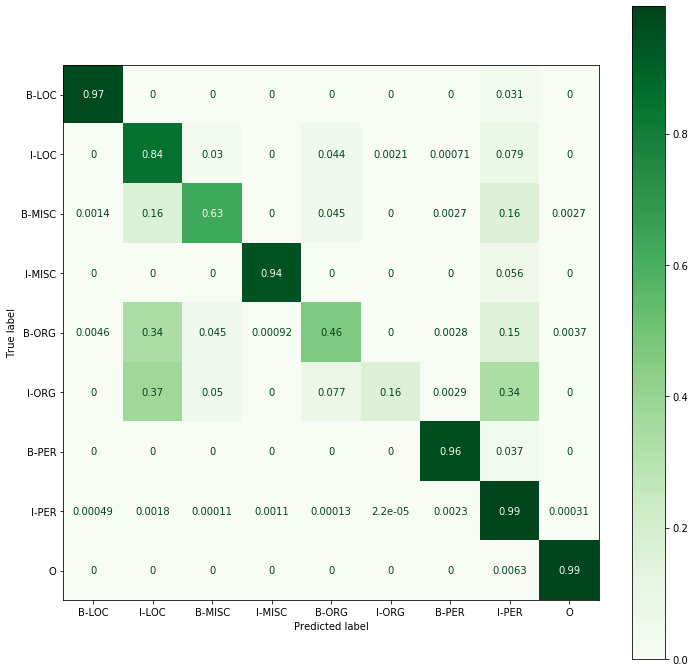

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

featureset, ty_true = sent2features(etb)
Xt = v.transform(featureset)
ty_pred = reg.predict(Xt)

class_names = ["B-LOC", "I-LOC" , "B-MISC" ,
                  "I-MISC" , "B-ORG" ,"I-ORG" , "B-PER", "I-PER", "O"]
disp = plot_confusion_matrix(reg, Xt, ty_true,
                                 display_labels=class_names,
                                 cmap=plt.cm.Greens,
                                 normalize="true")

plt.rcParams['figure.figsize'] = [12, 12]
plt.show()

Let's repeat the process for dutch:

0.9514686762013427
              precision    recall  f1-score   support

       B-LOC       0.44      0.53      0.48       479
       I-LOC       0.94      0.91      0.92        64
      B-MISC       0.69      0.44      0.54       748
      I-MISC       0.66      0.79      0.72       215
       B-ORG       0.85      0.17      0.29       686
       I-ORG       0.96      0.89      0.92       396
       B-PER       0.68      0.35      0.46       703
       I-PER       0.98      0.98      0.98       423

   micro avg       0.73      0.52      0.61      3714
   macro avg       0.77      0.63      0.66      3714
weighted avg       0.75      0.52      0.58      3714
 samples avg       0.05      0.05      0.05      3714



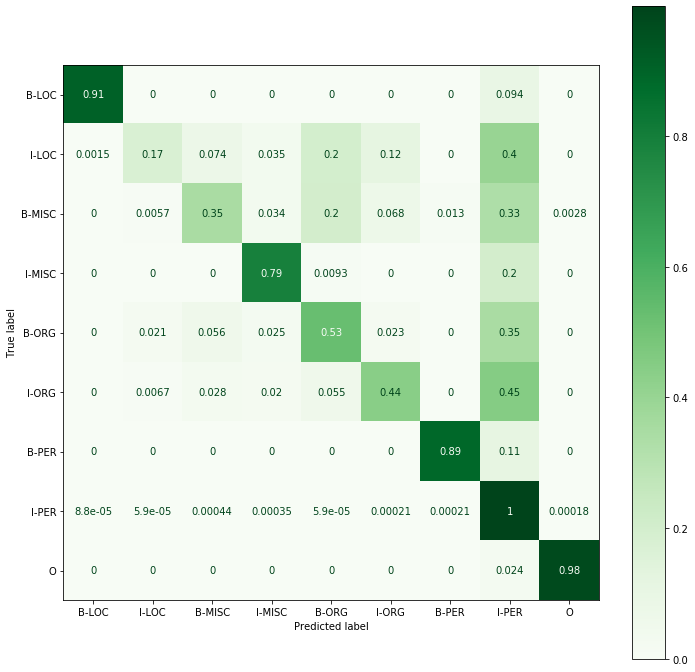

In [29]:
v = DictVectorizer(sparse=True)
featureset, y_true = sent2features(dtr[:500])
X = v.fit_transform(featureset)

# The ‘log’ loss gives logistic regression
reg = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss='log')
reg.partial_fit( X,  y_true, classes = all_classes)

i = 100
while i < len(dtr):
    if i + 100 < len(dtr):
        featureset, y_true = sent2features(dtr[i:i+100])
    else:
        featureset, y_true = sent2features(dtr[i:])
    X = v.transform(featureset)
    reg.partial_fit( X,  y_true)
    i += 100
    

featureset, ty_true = sent2features(dta)
Xt = v.transform(featureset)
ty_pred = reg.predict(Xt)

print(sklearn.metrics.accuracy_score(ty_true, ty_pred))

print(bio_classification_report(ty_true, ty_pred))

disp = plot_confusion_matrix(reg, Xt, ty_true,
                                 display_labels=class_names,
                                 cmap=plt.cm.Greens,
                                 normalize="true")

plt.rcParams['figure.figsize'] = [12, 12]
plt.show()

3.1.3. count_illegal_tags counts the occurrence of BIO tags sequences which are illegal (O-IX, IX-IY, BX-IY).

we'll use it to to find the  frequency of illegal tags transitions.

In [30]:
def count_illegal_tags(tags):
    O_IX = 0
    IX_IY = 0
    BX_IY = 0
    for i in range(len(tags)):
        if i == 0:  # skip first
            continue
        if tags[i - 1][0] == "O" and tags[i][0] == "I":
            O_IX += 1
        elif tags[i - 1][0] == "I" and tags[i][0] == "I":
            IX_IY += 1
        else:  # "BX_IY" case
            if tags[i][0] == "I" and not tags[i - 1][2:] == tags[i][:2]:
                BX_IY += 1
    print("out of", len(tags) - 1, "tags transitions", O_IX + IX_IY + BX_IY, "were illegal:")
    print(O_IX, "were of O_IX type")
    print(IX_IY, "were of IX-IY type")
    print(BX_IY, "were of BX_IY type")
    
tags = [index_to_label(x) for x in ty_pred]
count_illegal_tags(tags)

out of 37686 tags transitions 1108 were illegal:
333 were of O_IX type
220 were of IX-IY type
555 were of BX_IY type


### Q3.2 Using Word Embeddings

We updated word2features to include word embeddings (current word, previous word, next word) in the features of each word feature.

The model we chose is in Spanish:

In [31]:
from gensim.models import FastText
import gensim
embedding_dict = gensim.models.KeyedVectors.load_word2vec_format("cc.es.300.vec", limit=200000, binary=False)
embedding_dict.save_word2vec_format("cc.es.300.vec"+".bin", binary=True)
model = gensim.models.KeyedVectors.load_word2vec_format("cc.es.300.vec"+".bin", binary=True)

all_words = []

def word2features2(sentence, i, history):
    word = sentence[i][0]
    all_words.append(word)
    features = {              
                 "POS": sentence[i][1],
                 "prefix(1)": word[:1],
                 "prefix(2)": word[:2],
                 "prefix(3)": word[:3],
                 "suffix(1)": word[-1:],
                 "suffix(2)": word[-2:],
                 "suffix(3)": word[-3:],
                
                 }
    #add the Word Embeddings to the features
    k = 0
    if word in model.vocab.keys():
        for a in model.get_vector(word):
            k += 1
            features["c"+str(k)] = a
    if i != 0:
        if sentence[i-1][0] in model.vocab.keys():
            for a in model.get_vector(sentence[i-1][0]):
                k += 1
                features["p"+str(k)] = a
    if i != len(sentence) - 1:
        if sentence[i+1][0] in model.vocab.keys():
            for a in model.get_vector(sentence[i+1][0]):
                k += 1
                features["n"+str(k)] = a
        
    return features

all_classes = [i for i in range(9)]

v = DictVectorizer(sparse=True)
featureset, y_true = sent2features(etr[:500])
X = v.fit_transform(featureset)

# The ‘log’ loss gives logistic regression
reg = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss='log')
reg.partial_fit( X,  y_true, classes = all_classes)

#partial_fit 100 sentences at a time 
i = 100
while i < len(etr):
    if i + 100 < len(etr):
        featureset, y_true = sent2features(etr[i:i+100])
    else:
        featureset, y_true = sent2features(etr[i:])
    X = v.transform(featureset)
    reg.partial_fit( X,  y_true)
    i += 100
    
ty_true= []
ty_pred = np.array([])
for i in range(len(etb)):
    featureset, yt = sent2features([etb[i]])
    ty_true += yt
    Xt = v.transform(featureset)
    ty_pred = np.concatenate([ty_pred,reg.predict(Xt)])
    
ty_pred = ty_pred.astype(np.int64)

print("accuracy: ",sklearn.metrics.accuracy_score(ty_true, ty_pred), "\n")
print(bio_classification_report(ty_true, ty_pred))    


accuracy:  0.9656530766693187 

              precision    recall  f1-score   support

       B-LOC       0.81      0.44      0.57      1084
       I-LOC       0.92      0.97      0.94       325
      B-MISC       0.94      0.14      0.24       339
      I-MISC       0.91      0.94      0.93       557
       B-ORG       0.62      0.86      0.72      1400
       I-ORG       0.91      0.96      0.93      1104
       B-PER       0.82      0.60      0.69       735
       I-PER       0.97      0.99      0.98       634

   micro avg       0.80      0.76      0.78      6178
   macro avg       0.86      0.74      0.75      6178
weighted avg       0.82      0.76      0.76      6178
 samples avg       0.09      0.09      0.09      6178

